In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split


# For EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
# Importing the data directly from Google colab

data = np.loadtxt(open('sample_data/mnist_train_small.csv','rb'),delimiter=',')

In [5]:
# Dividing the data into labels and data
labels = data[:,0]
data = data[:,1:]

labels.shape, data.shape

((20000,), (20000, 784))

In [71]:
np.max(data)

255.0

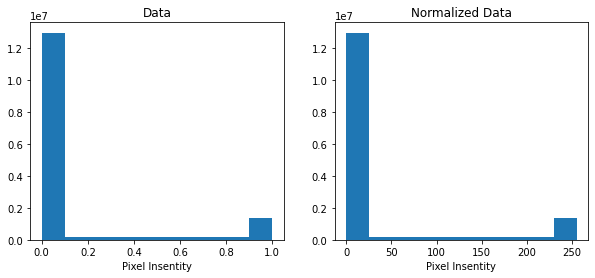

In [6]:
# Normalization of data (0 - 1)
norm_data = data / np.max(data)

fig,ax = plt.subplots(1,2,figsize=(10,4))
ax[0].hist(norm_data.flatten())
ax[0].set_xlabel("Pixel Insentity")
ax[0].set_title('Data')
ax[1].hist(data.flatten())
ax[1].set_xlabel("Pixel Insentity")
ax[1].set_title('Normalized Data')

plt.show()

In [7]:
# Converting it to Tensor

data = torch.tensor( data ).float()
labels = torch.tensor( labels ).long()

In [24]:
# Convert tensors into Dataloader objects

#Split into train and test
train_data, test_data, train_label, test_label = train_test_split(data, labels, test_size=0.1)

# Converting to PyTorch Tensor Datasets
train_data = TensorDataset(train_data, train_label)
test_data = TensorDataset(test_data, test_label)

# Converting into Dataloader
train_loader = DataLoader(train_data,  batch_size= 32, drop_last=True, shuffle=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

In [62]:
def create_net():

  # Creating a Pytorch class for archieture
  class MNISTnet(nn.Module):
    def __init__(self):
      super().__init__()

      # Input layer
      self.input = nn.Linear(784,64)

      # Hidden Layer 1
      self.fc1 = nn.Linear(64,32)
      # Hidden Layer 2
      self.fc2 = nn.Linear(32,32)

      # Output Layer
      self.output = nn.Linear(32,10)

    def forward(self,x):
      # Input layer
      x = F.relu(self.input(x))

      # FC1 - Hidden Layer
      x = F.relu(self.fc1(x))
      # FC2 - Hidden Layer
      x = F.relu(self.fc2(x)) 

      return torch.log_softmax(self.output(x), axis = 1)

  # Creating the net
  net = MNISTnet()
  
  # Loss function , Negative log- likehold loss
  loss_func = nn.NLLLoss()

  # Optimizer
  optimizer = torch.optim.SGD(net.parameters(),lr = 0.01)

  return net, loss_func, optimizer


In [58]:
# Testing the model created
net, loss_func, optimizer = create_net()

X,y = next(iter(train_loader))
yHat = net(X)
loss = loss_func(yHat,y)

loss.detach()

tensor(5.8115)

In [63]:
# Training the model created

def train_net(train_loader, test_loader,net,loss_func,optimizer):

  numepochs = 50
  trainAcc = []
  testAcc = []
  losses = []

  

  for epochi in range(numepochs):

    batchAcc = []
    batchLoss = []
    batch_num = 0
    print(f'Epoch -{epochi} ')
    print(f'***************************')
    for X,y in train_loader:

      # Foward pass
      yHat = net(X)
      loss = loss_func(yHat,y)
      
      # Backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # Storing Batch loss
      batch_num += 1
      print(f' Batch: {batch_num} Loss: {loss.detach()}')
      batchLoss.append(loss.item())

      # Computing Accuracy
      matches = torch.argmax(yHat, axis = 1) == y
      matches_num = matches.float()
      accuracy = 100 * torch.mean(matches_num)

      # Storing Batch accuracy
      batchAcc.append(accuracy)

      # End of Batch Loop
    print(f'***************************')
    
    # Average of Batch Accuracy gives as the training Acc
    trainAcc.append(np.mean(batchAcc))

    # Average of Batch Losses gives as the losses over each epoch
    losses.append(np.mean(batchLoss))


    # Test Accuracy
    X,y = next(iter(train_loader))
    
    # Switching off Gradient calculations
    with torch.no_grad():
      # Foward pass
      yHat = net(X)
      loss = loss_func(X,y)

      # Appending test Accuracy
    testAcc.append(100 * torch.mean((torch.argmax(yHat,axis=1) == y).float()))

    # End of Epochs

  return trainAcc, testAcc, losses

In [64]:
MINIST_net, loss_func, optimizer = create_net()

trainAcc, testAcc, losses = train_net(train_loader, test_loader, MINIST_net, loss_func, optimizer )

Streaming output truncated to the last 5000 lines.
 Batch: 84 Loss: 0.0002800796355586499
 Batch: 85 Loss: 0.000284276669844985
 Batch: 86 Loss: 9.547113222652115e-06
 Batch: 87 Loss: 0.001000401098281145
 Batch: 88 Loss: 9.986064105760306e-05
 Batch: 89 Loss: 3.182559521519579e-05
 Batch: 90 Loss: 1.3028415196458809e-05
 Batch: 91 Loss: 0.00013099046191200614
 Batch: 92 Loss: 0.00017226164345629513
 Batch: 93 Loss: 5.812837844132446e-05
 Batch: 94 Loss: 1.1971272215305362e-05
 Batch: 95 Loss: 0.00017388405103702098
 Batch: 96 Loss: 9.981775656342506e-05
 Batch: 97 Loss: 1.0858668247237802e-05
 Batch: 98 Loss: 0.0003177478793077171
 Batch: 99 Loss: 0.00018046528566628695
 Batch: 100 Loss: 0.00017066256259568036
 Batch: 101 Loss: 8.131562208291143e-05
 Batch: 102 Loss: 1.0120297702087555e-05
 Batch: 103 Loss: 1.5497112144657876e-06
 Batch: 104 Loss: 2.8011851100018248e-05
 Batch: 105 Loss: 0.00016720342682674527
 Batch: 106 Loss: 0.0009103499469347298
 Batch: 107 Loss: 3.266962721681921

Text(0, 0.5, 'Losses')

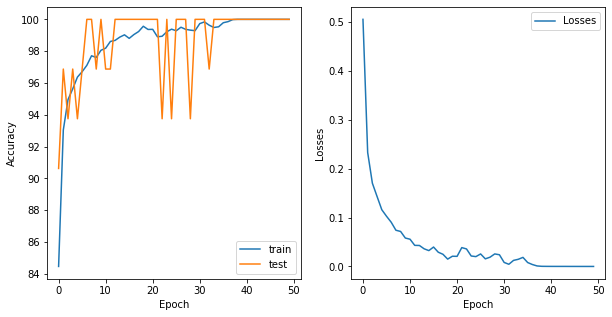

In [65]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].plot(trainAcc, label='train')
ax[0].plot(testAcc, label ='test')
ax[0].legend()
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Accuracy")

ax[1].plot(losses, label='Losses')
ax[1].legend()
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Losses")

